In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

import sys
import os
# sys.path.append("/Users/clemens/Documents/cour ses/DS-Lab/Baselines")
#sys.path.append("/home/elvis/MEGA/ETH/Projects/DSLab/DSLab-StackOverflow/Baselines")

# import gp_features

In [17]:
def available_runs(folder):
    assert(os.path.isdir(folder))
    
    all_files = os.listdir(folder)
    run_files = sorted([f for f in all_files if f[:11] == 'run_summary'])
    print("Available run summaries>>> \n {}".format(run_files))
    
    with_full_path = [os.path.join(folder, f) for f in run_files]
    return with_full_path




In [18]:
runs = available_runs("../cache/gp/runs")
# runs = available_runs(os.environ['SCRATCH'] + "/runs")

with open(runs[-1], "rb") as f:
    summary = pickle.load(f)
    
print(summary.keys())
print(summary['params'])
info = summary['gp_run_info']
used_from_gp = summary['used_questions']
# used_from_gp = pd.read_csv("../Baselines/events_used_by_gp.csv")
# info = pd.read_csv("../Baselines/gp_run_info_dict.csv")
# used_from_gp.loc[:, 'answer_id'] = info.answer_id
# used_from_gp.loc[:, 'predicted_for_user'] = info.user_id
# assert(len(info)==len(used_from_gp))

Available run summaries>>> 
 ['run_summary_12_07__11_11.pickle', 'run_summary_12_07__11_16.pickle', 'run_summary_12_07__22_02.pickle', 'run_summary_12_08__15_25.pickle']
dict_keys(['used_questions', 'training_set_for_gp', 'gp_run_info', 'params', 'all_mus', 'all_sigmas'])
{'model_choice': 'osgpr', 'm': 100, 'kernel': 'linear', 'k_var': 1.0, 'k_len': 0.8, 'pretrain_steps': 50, 'opt_steps': 20, 'verbose_opt': 'pretraining', 'save_n_neg': 1, 'only_use_features': 'votes_sd affinity_sum tag_popularity votes_mean question_age', 'sum_file_path': '../cache/gp/runs/', 'save_every_n': 100, 'redo_pretraining': False, 'cache_file_path': '../cache', 'log_mu_sigma': True}


In [27]:
summary["all_mus"]
# summary["all_sigmas"]

{Timestamp('2015-01-01 00:26:32.347000'): array([-0.0269588 , -0.01915543, -0.00630511, -0.00515765, -0.01464024,
        -0.01902037,  0.01096433, -0.00224305, -0.00255255,  0.01004717,
        -0.00872854, -0.02670321, -0.02658194, -0.02062104, -0.01483288,
        -0.00852371, -0.01653068, -0.01581081, -0.01526977, -0.01448846,
        -0.01223   , -0.01058354, -0.00840839, -0.0039024 ]),
 Timestamp('2015-01-01 04:24:47.033000'): array([-0.00896451,  0.30847874,  0.01488232,  0.05170359, -0.01805709,
         0.29093086,  0.01190192,  0.01184527,  0.01723513,  0.15206043,
         0.0071449 ,  0.15011765,  0.09260076, -0.00808712,  0.19120003,
        -0.01418704, -0.01572738, -0.01123285,  0.00365839, -0.01290793,
         0.0086618 ]),
 Timestamp('2015-01-01 08:42:21.977000'): array([-0.02446213, -0.01957078, -0.02726152, -0.0126334 , -0.01449609,
        -0.00066051, -0.0151598 , -0.01154756, -0.02284572, -0.03098258,
        -0.03063483, -0.02840874, -0.02938128, -0.02859879, -0

In [28]:
def compute_chance_success(n_candidates_list, n):
    p = n/np.array(n_candidates_list)
    p[p>1] = 1 # if there n_preds smaller then candidate list
    return p

In [32]:
win_size = 50
info.loc[:, "is_found"] = (info.predicted_rank != -1)*1.0
info.loc[:, "chance_success"] = compute_chance_success(info.n_candidates, 5)
r_mean = info.is_found.rolling(win_size).mean()
c_mean = info.chance_success.rolling(win_size).mean()

In [33]:
info.loc[:, "event_time"] = pd.to_datetime(info.event_time)
time_indx = pd.to_timedelta(info.event_time- info.event_time.min()) / pd.Timedelta(365, 'D')

Text(0.5, 0, 'time from start of online learning [years]')

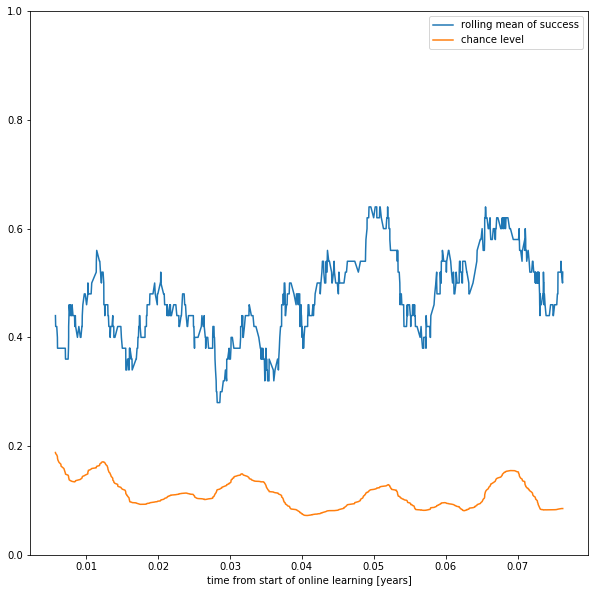

In [36]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean, label='rolling mean of success')
plt.plot(time_indx.values, c_mean, label='chance level')
plt.legend()
plt.ylim(0, 1)
plt.xlabel("time from start of online learning [years]")

(0, 0.5)

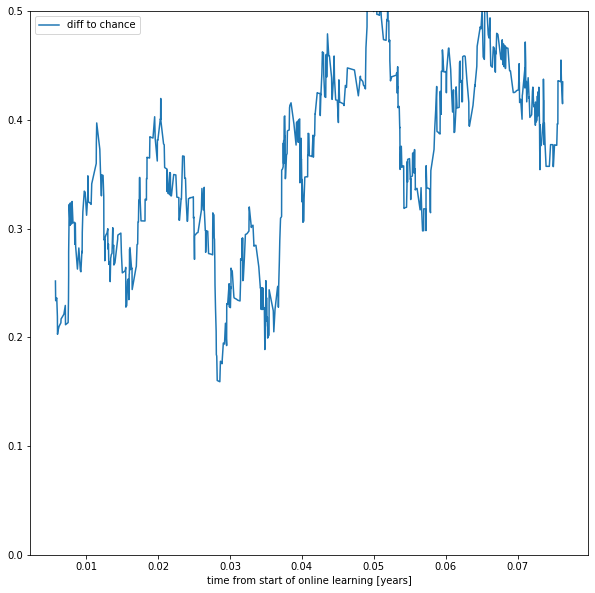

In [37]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean-c_mean, label='diff to chance')
plt.legend()
plt.xlabel("time from start of online learning [years]")
plt.ylim(0, 0.5)

In [8]:
gpr = GaussianProcessRegressor(kernel=DotProduct(), random_state=0, alpha=1e-5)

In [9]:
vals = training_set_for_gp.values
l = np.array(observed_labels)
nnn = 70000
vals, l = vals[nnn:], l[nnn:]
vals.shape

NameError: name 'training_set_for_gp' is not defined

In [12]:
DotProduct()(vals)

array([[42296.        ,  8152.        ,  8152.        , ...,
         5347.        , 17587.        , 17587.        ],
       [ 8152.        ,  8153.00010851,  8153.00010851, ...,
         5347.        ,  5347.        ,  5347.        ],
       [ 8152.        ,  8153.00010851,  8153.00010851, ...,
         5347.        ,  5347.        ,  5347.        ],
       ...,
       [ 5347.        ,  5347.        ,  5347.        , ...,
         3770.        ,  3770.        ,  3770.        ],
       [17587.        ,  5347.        ,  5347.        , ...,
         3770.        ,  8158.        ,  8158.        ],
       [17587.        ,  5347.        ,  5347.        , ...,
         3770.        ,  8158.        ,  8158.        ]])

In [13]:
gpr.fit(vals, l)

GaussianProcessRegressor(alpha=1e-05, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=0)

In [15]:
mu, sigma = gpr.predict(vals[-10:, :], return_std=True)

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


### OSGPR

In [3]:
used_from_gp = pd.read_csv("../Baselines/events_used_by_gp.csv")
info = pd.read_csv("../Baselines/gp_run_info_dict_osgpr.csv")

In [4]:
used_from_gp.iloc[-35:-25]

,Unnamed: 0,question_id,question_date,question_body,question_owner_user_id,question_title,question_tags,question_closed_date,date_of_accepted_ans,label
23300,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23301,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23302,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23303,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23304,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23305,120280,86852,2014-02-17 12:53:58.363,<p>It's quite common to normalise different fe...,9007.0,Normalising higher moments of features for mac...,<machine-learning><normalization>,NaN,NaN,1.0
23306,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23307,120290,86876,2014-02-17 16:12:04.060,<p>We are trying to design a data repository f...,40410.0,Any suggestions for storing diverse data sets ...,<data-visualization><dataset><database>,NaN,NaN,0.0
23308,12075,86889,2014-02-17 17:14:53.310,<p>I calculated the least-squares means and st...,10339.0,lsmeans vs. differences between lsmeans,<r><statistical-significance><standard-error><...,NaN,2014-02-18 08:39:04.097,0.0
23309,12075,86889,2014-02-17 17:14:53.310,<p>I calculated the least-squares means and st...,10339.0,lsmeans vs. differences between lsmeans,<r><statistical-significance><standard-error><...,NaN,2014-02-18 08:39:04.097,0.0


In [6]:
win_size = 500
info.loc[:, "is_found"] = (info.predicted_rank != -1)*1.0
info.loc[:, "chance_success"] = compute_chance_success(info.n_candidates, 5)
r_mean = info.is_found.rolling(win_size).mean()
c_mean = info.chance_success.rolling(win_size).mean()

In [7]:
info.loc[:, "event_time"] = pd.to_datetime(info.event_time)
time_indx = pd.to_timedelta(info.event_time- info.event_time.min()) / pd.Timedelta(365, 'D')

Text(0.5, 0, 'time from start of online learning [years]')

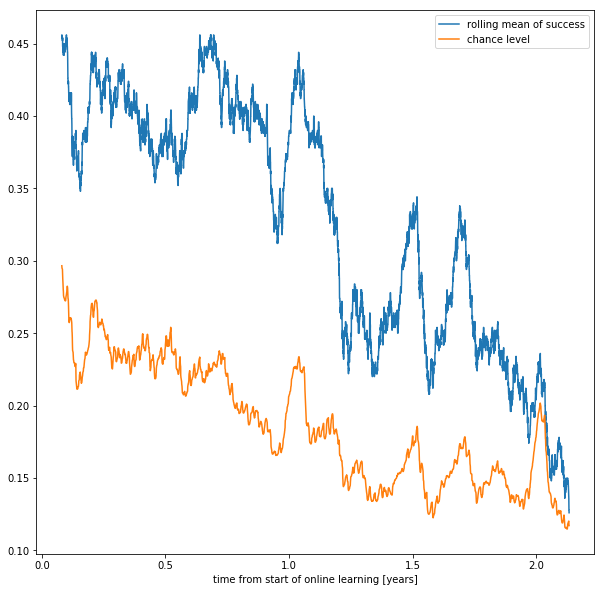

In [8]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean, label='rolling mean of success')
plt.plot(time_indx.values, c_mean, label='chance level')
plt.legend()
plt.xlabel("time from start of online learning [years]")

Text(0.5, 0, 'time from start of online learning [years]')

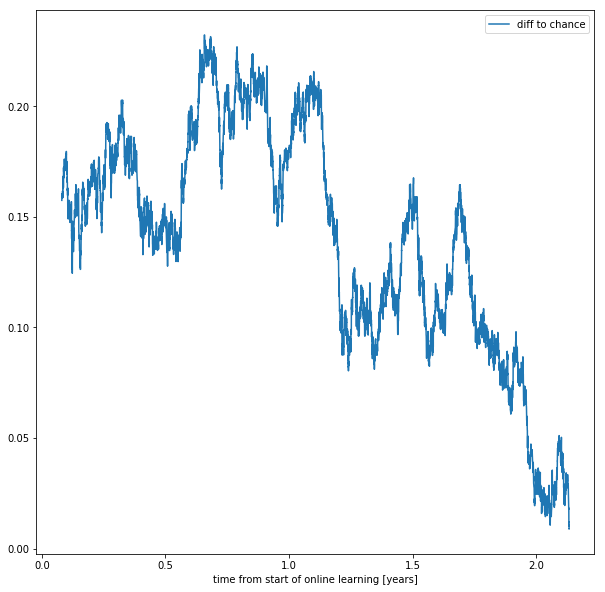

In [9]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean-c_mean, label='diff to chance')
plt.legend()
plt.xlabel("time from start of online learning [years]")